**Business Question**

How can we group customers into clusters (e.g., "Champions," "At-Risk," "New Customers") based on their Recency, Frequency, Monetary and Tenure (RFMT) value to guide business actions and marketing strategies?

**Features Used**

frequency 
- definition: number of repeat purchases the customer has made (one less than the total number of purchases)
- calculation: count of time periods the customer had a purchase in (if using days as units, then it’s the count of days the customer had a purchase on)

tenure
- definition: age of the customer in whatever time units chosen
- calculation: duration between a customer’s first purchase and the end of the period under study

recency
- definition: age of the customer when they made their most recent purchases
- calculation: duration between a customer’s first purchase and their latest purchase (if they have made only 1 purchase, the recency is 0)

monetary
- definition: average value of a given customer’s purchases
- calculation: sum of all a customer’s purchases divided by the total number of purchases

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer

from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('data/customer_rfmt_final.csv')
df.head()

CustomerID  frequency  recency  tenure    monetary
0     12347.0        6.0    365.0   367.0  599.701667
1     12348.0        3.0    283.0   358.0  261.480000
2     12352.0        5.0    260.0   296.0  193.782000
3     12356.0        2.0    303.0   325.0  269.905000
4     12358.0        1.0    149.0   150.0  523.200000

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  2764 non-null   float64
 1   frequency   2764 non-null   float64
 2   recency     2764 non-null   float64
 3   tenure      2764 non-null   float64
 4   monetary    2764 non-null   float64
dtypes: float64(5)
memory usage: 108.1 KB


In [4]:
df['CustomerID'] = df['CustomerID'].astype('object')

In [5]:
df.describe()

frequency      recency       tenure     monetary
count  2764.000000  2764.000000  2764.000000  2764.000000
mean      4.417511   204.397612   260.641100   404.876384
std       6.856056   110.859528   101.000339   489.063612
min       1.000000     1.000000     9.000000     6.783333
25%       1.000000   107.000000   198.000000   186.065000
50%       3.000000   212.000000   284.000000   307.530000
75%       5.000000   302.000000   358.000000   453.625000
max     128.000000   373.000000   373.000000  9349.477200

In [6]:
frequency_95th = df['frequency'].quantile(0.95)
frequency_99th = df['frequency'].quantile(0.99)
frequency_max = df['frequency'].max()
monetary_95th = df['monetary'].quantile(0.95)
monetary_99th = df['monetary'].quantile(0.99)
monetary_max = df['monetary'].max()

print(f"95th Percentile of Frequency: {frequency_95th}")
print(f"99th Percentile of Frequency: {frequency_99th}")
print(f"95th Percentile of Monetary: {monetary_95th}")
print(f"99th Percentile of Monetary: {monetary_99th}")
print(f"Max of Frequency: {frequency_max}")
print(f"Max of Monetary: {monetary_max}")

95th Percentile of Frequency: 14.0
99th Percentile of Frequency: 28.0
95th Percentile of Monetary: 999.8389999999998
99th Percentile of Monetary: 2281.4055449999983
Max of Frequency: 128.0
Max of Monetary: 9349.4772


- 99% of customers have monetary of 2281 or less but maximum monetary is extremely high amounting to 9349
- 99% of customers have frequency of 28 or less but maximum frequency is extremely high amounting to 128
- Frequency and Monetary have outliers that skew the data
- Transformations (e.g., log transformation) or outlier handling (e.g., capping) might be necessary.

1. Check Anomalies

In [7]:
df_anomalies = df[['CustomerID', 'frequency', 'monetary']]
df_anomalies_scaled = StandardScaler().fit_transform(df_anomalies[['frequency', 'monetary']])

isolation_forest = IsolationForest(contamination=0.03, random_state=42)
df_anomalies['outlier'] = isolation_forest.fit_predict(df_anomalies_scaled)

C:\Users\PREDATOR HELIOS 300\AppData\Local\Temp\ipykernel_26888\3851434468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalies['outlier'] = isolation_forest.fit_predict(df_anomalies_scaled)


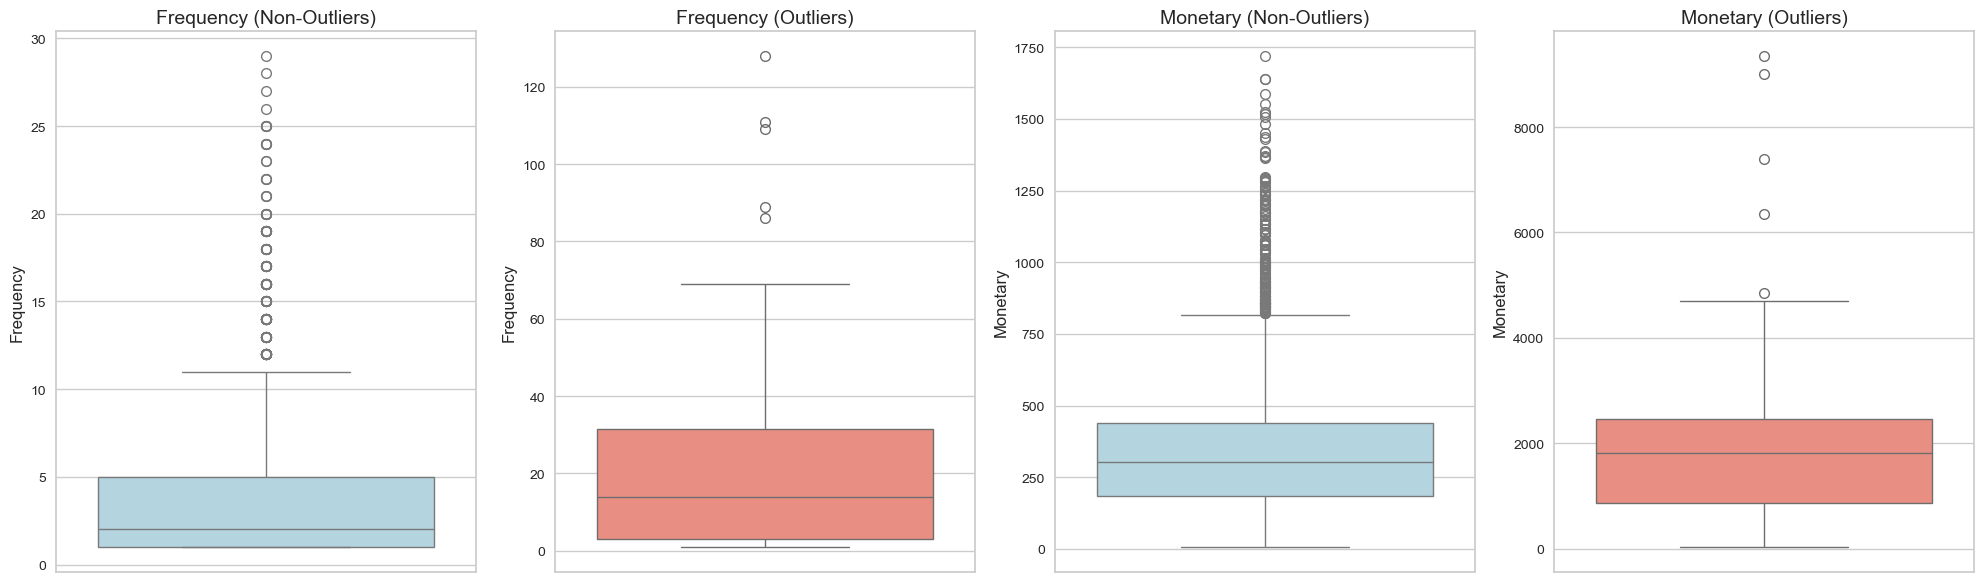

In [8]:
# Separate outliers and non-outliers
outliers = df_anomalies[df_anomalies['outlier'] == -1]
non_outliers = df_anomalies[df_anomalies['outlier'] == 1]

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Box plot for Frequency (Non-Outliers)
sns.boxplot(data=non_outliers, y='frequency', ax=axes[0], color='lightblue')
axes[0].set_title('Frequency (Non-Outliers)', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=12)

# Box plot for Frequency (Outliers)
sns.boxplot(data=outliers, y='frequency', ax=axes[1], color='salmon')
axes[1].set_title('Frequency (Outliers)', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=12)

# Box plot for Monetary (Non-Outliers)
sns.boxplot(data=non_outliers, y='monetary', ax=axes[2], color='lightblue')
axes[2].set_title('Monetary (Non-Outliers)', fontsize=14)
axes[2].set_ylabel('Monetary', fontsize=12)

# Box plot for Monetary (Outliers)
sns.boxplot(data=outliers, y='monetary', ax=axes[3], color='salmon')
axes[3].set_title('Monetary (Outliers)', fontsize=14)
axes[3].set_ylabel('Monetary', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
df['outlier'] = df_anomalies['outlier']
df_all = df.copy()

df = df[df['outlier'] == 1]
df = df.drop(columns=['outlier'])

print("Number of outliers removed:", df_all.shape[0] - df.shape[0])
print("Remaining data points:", df.shape[0])

Number of outliers removed: 83
Remaining data points: 2681


In [10]:
df_all[df_all['outlier'] == 1].describe()

frequency      recency       tenure     monetary  outlier
count  2681.000000  2681.000000  2681.000000  2681.000000   2681.0
mean      3.843342   201.693398   258.881015   352.649783      1.0
std       3.953187   109.944066   100.855436   244.700138      0.0
min       1.000000     1.000000     9.000000     6.783333      1.0
25%       1.000000   106.000000   197.000000   184.094000      1.0
50%       2.000000   210.000000   282.000000   302.536667      1.0
75%       5.000000   297.000000   357.000000   437.670000      1.0
max      29.000000   373.000000   373.000000  1720.103333      1.0

In [11]:
df_all[df_all['outlier'] == -1].describe()

frequency     recency      tenure     monetary  outlier
count   83.000000   83.000000   83.000000    83.000000     83.0
mean    22.963855  291.746988  317.493976  2091.858510     -1.0
std     26.723720  105.281023   88.929593  1769.892515      0.0
min      1.000000    1.000000   18.000000    34.379118     -1.0
25%      3.000000  260.500000  309.000000   870.534202     -1.0
50%     14.000000  340.000000  362.000000  1825.740000     -1.0
75%     31.500000  365.000000  371.000000  2464.015000     -1.0
max    128.000000  373.000000  373.000000  9349.477200     -1.0

2. Check Skewness

In [12]:
skewness = df_all.select_dtypes(include=['float64', 'int64']).skew()
display(skewness)

frequency    7.982490
recency     -0.162304
tenure      -0.763926
monetary     8.195003
outlier     -5.510455
dtype: float64

- Frequency and Monetary are overwhelmingly positively skewed if we include outliers

In [13]:
skewness = df.select_dtypes(include=['float64', 'int64']).skew()
display(skewness)

frequency    2.418548
recency     -0.141276
tenure      -0.742728
monetary     1.773335
dtype: float64

- After removing outliers, Frequency and Monetary are positively skewed. 
- We explore log transformations.

3. Log Transformations on Frequency and Monetary

In [14]:
df['monetary_log'] = df['monetary'].apply(lambda x: np.log1p(x))
df['frequency_log'] = df['frequency'].apply(lambda x: np.log1p(x))
df.head()

CustomerID  frequency  recency  tenure    monetary  monetary_log  \
0    12347.0        6.0    365.0   367.0  599.701667      6.398098   
1    12348.0        3.0    283.0   358.0  261.480000      5.570175   
2    12352.0        5.0    260.0   296.0  193.782000      5.271881   
3    12356.0        2.0    303.0   325.0  269.905000      5.601768   
4    12358.0        1.0    149.0   150.0  523.200000      6.261873   

   frequency_log  
0       1.945910  
1       1.386294  
2       1.791759  
3       1.098612  
4       0.693147

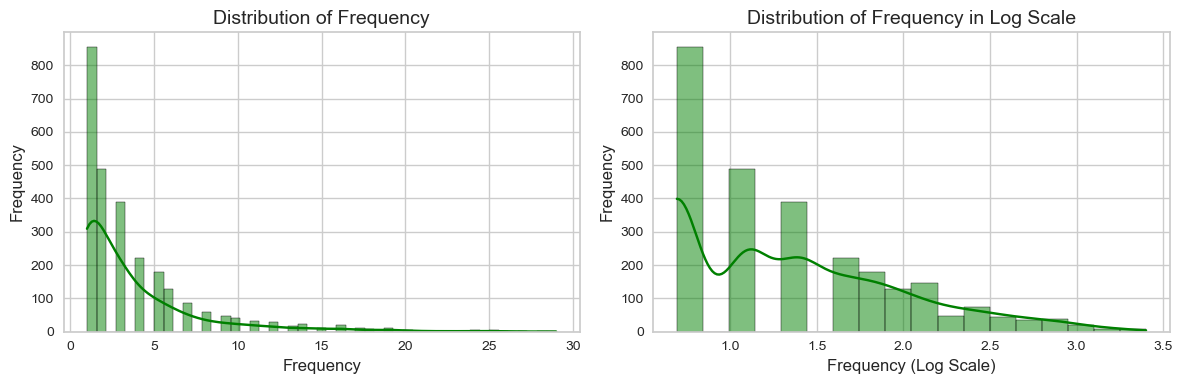

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution plot
sns.histplot(df['frequency'], kde=True, ax=axes[0], color='green')
axes[0].set_title('Distribution of Frequency', fontsize=14)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Distribution plot
sns.histplot(df['frequency_log'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Frequency in Log Scale', fontsize=14)
axes[1].set_xlabel('Frequency (Log Scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

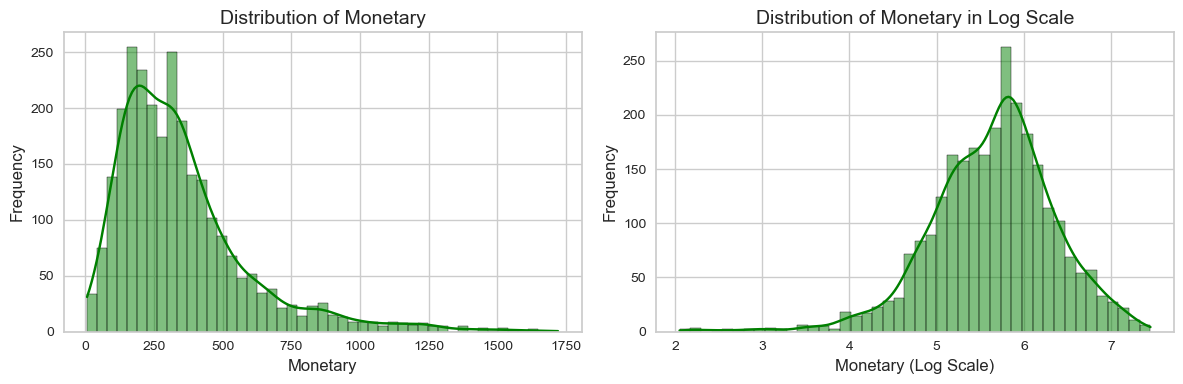

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution plot
sns.histplot(df['monetary'], kde=True, ax=axes[0], color='green')
axes[0].set_title('Distribution of Monetary', fontsize=14)
axes[0].set_xlabel('Monetary', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Distribution plot
sns.histplot(df['monetary_log'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Monetary in Log Scale', fontsize=14)
axes[1].set_xlabel('Monetary (Log Scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

In [17]:
skewness = df.select_dtypes(include=['float64', 'int64']).skew()
display(skewness)

frequency        2.418548
recency         -0.141276
tenure          -0.742728
monetary         1.773335
monetary_log    -0.632224
frequency_log    0.781910
dtype: float64

4. Visualizing Features

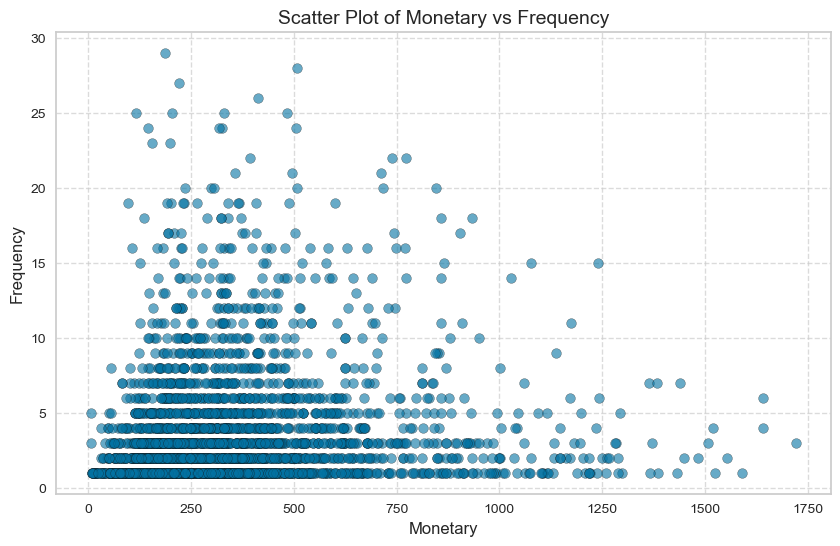

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df['monetary'], df['frequency'], alpha=0.6, edgecolors='k')
plt.title('Scatter Plot of Monetary vs Frequency', fontsize=14)
plt.xlabel('Monetary', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

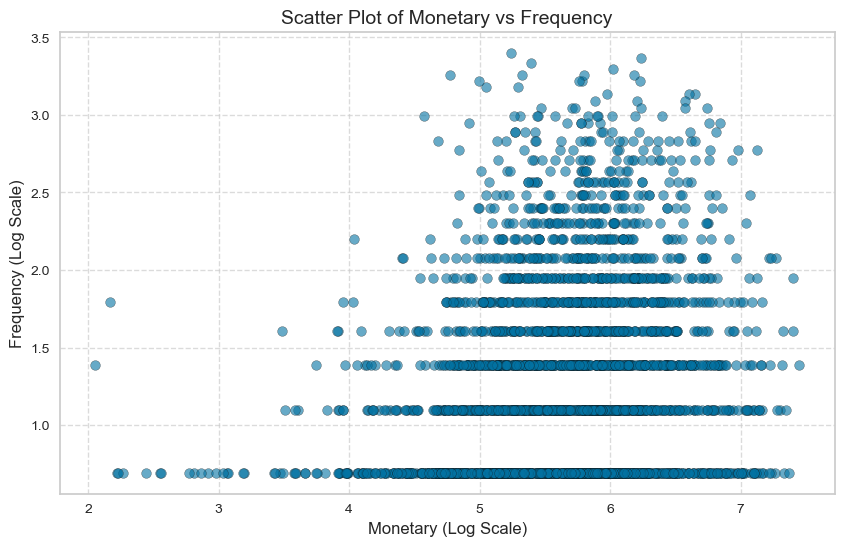

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(df['monetary_log'], df['frequency_log'], alpha=0.6, edgecolors='k')
plt.title('Scatter Plot of Monetary vs Frequency', fontsize=14)
plt.xlabel('Monetary (Log Scale)', fontsize=12)
plt.ylabel('Frequency (Log Scale)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

- Dense Blob (Bottom-Left): 
    - "Low-Frequency" customers (infrequent customers)

- Top-Right: 
    - "High-Frequency, High-Monetary" customers (super-customers)

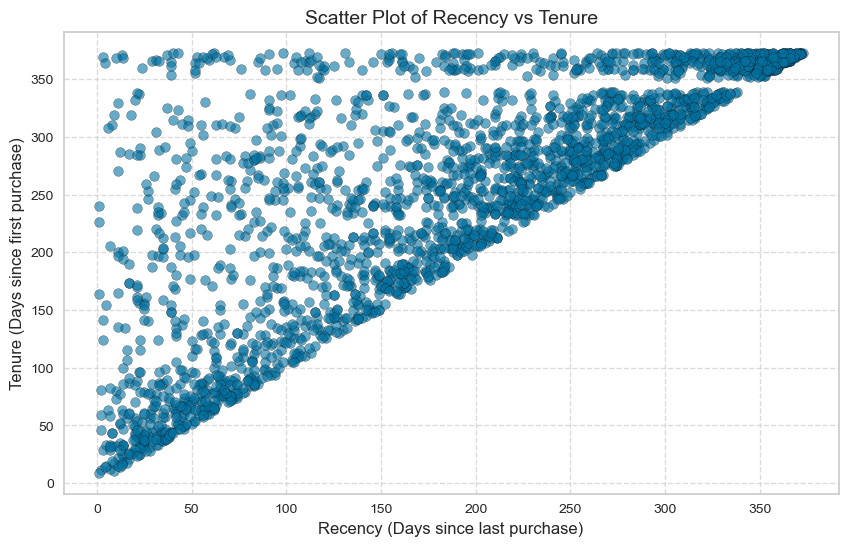

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(df['recency'], df['tenure'], alpha=0.6, edgecolors='k')
plt.title('Scatter Plot of Recency vs Tenure', fontsize=14)
plt.xlabel('Recency (Days since last purchase)', fontsize=12)
plt.ylabel('Tenure (Days since first purchase)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

- Dense Diagonal Line (Recency approx Tenure): 
    - Recency: Time between the customer's first transaction and their most recent transaction.
    - This line is so dense because a huge portion of your customer base consists of infrequent buyers.

- Points Below the Line (Recency < Tenure): 
    - Multi-time buyers where their last purchase is more recent than their first purchase.

- Empty Space Above the Line: Empty because a customer's Recency cannot be greater than their Tenure.

4. Scaling

In [21]:
df_features = df[['recency', 'frequency', 'monetary', 'tenure']]
df_features_log = df[['recency', 'frequency_log', 'monetary_log', 'tenure']]
df_customer = df[['CustomerID']]

df_features_scaled = StandardScaler().fit_transform(df_features)
df_features_log_scaled = StandardScaler().fit_transform(df_features_log)

df_scaled = np.hstack((df_customer.values, df_features_scaled))
df_scaled = pd.DataFrame(df_scaled, columns=['CustomerID', 'recency_scaled', 'frequency_scaled', 'monetary_scaled', 'tenure_scaled'])

df_scaled_log = np.hstack((df_customer.values, df_features_log_scaled))
df_scaled_log = pd.DataFrame(df_scaled_log, columns=['CustomerID', 'recency_scaled', 'frequency_log_scaled', 'monetary_log_scaled', 'tenure_scaled'])

K-Means Clustering
- Advantages:
    - Many common implementations.
    - Popular and well studied. 
    - Comparatively fast.
- Disadvantages:
    - Assumes spherical density. 
    - Sensitive to scale. 
    - Difficult to incorporate categorical variables. 
    - Sensitive to outliers. 
    - Sensitive to choice of seed.
    - Have to choose the number of clusters. 
    - Struggles with high dimensional data.


References:
- https://crunchingthedata.com/when-to-use-k-means-clustering/

Clustering Optimization: Elbow Method and Silhouette Analysis

- Elbow Method
    - WCSS (Within-Cluster Sum of Squares) is a measure of how "tight" the clusters are. Lower WCSS is better.
    - Elbow is the point where the WCSS stops dropping dramatically and begins to flatten out (point of diminishing returns).

- Silhouette Score
    - Silhouette Score measures how well-separated and dense the clusters are. Closer to 1 is better.


c:\Users\PREDATOR HELIOS 300\miniconda3\envs\rei-ecommerce\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


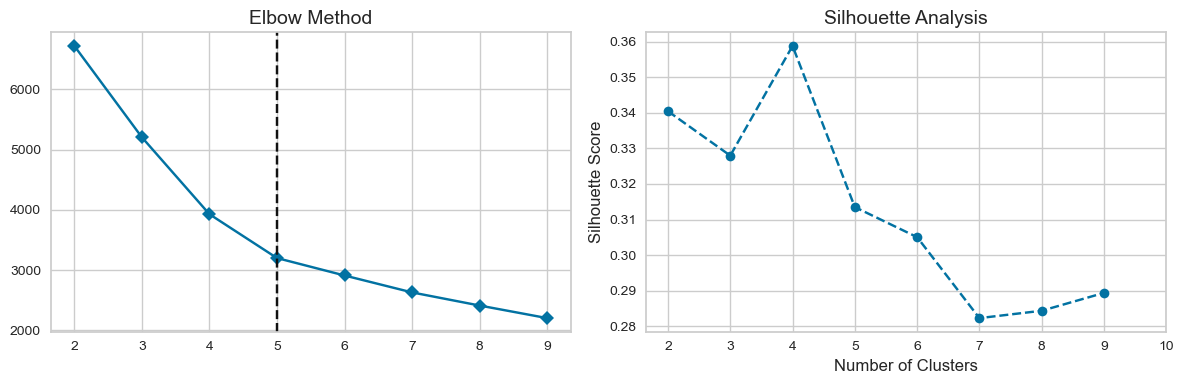

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow Method
km = KMeans(init='k-means++', n_init=10, max_iter=500, random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 10), timings=False, ax=axes[0])
visualizer.fit(df_features_scaled)
axes[0].set_title('Elbow Method', fontsize=14)

# Silhouette Analysis
silhouette_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=500, random_state=42)
    labels = km.fit_predict(df_features_scaled)
    score = silhouette_score(df_features_scaled, labels)
    silhouette_scores.append(score)

axes[1].plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
axes[1].set_title('Silhouette Analysis', fontsize=14)
axes[1].set_xlabel('Number of Clusters', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_xticks(range(2, 11))

plt.tight_layout()
plt.show()

- Elbow Method
    - Optimal Number of Clusters: 5

- Silhouette Score
    - Optimal Number of Clusters: 4

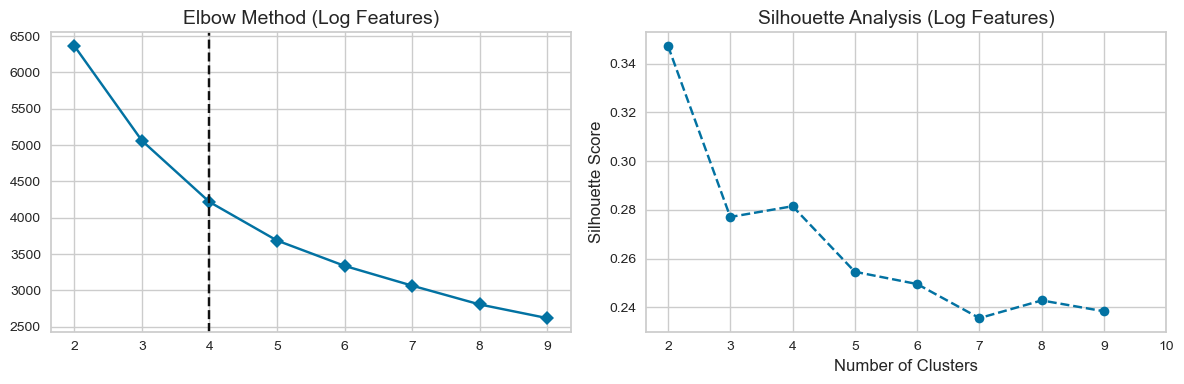

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow Method
km = KMeans(init='k-means++', n_init=10, max_iter=500, random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 10), timings=False, ax=axes[0])
visualizer.fit(df_features_log_scaled)
axes[0].set_title('Elbow Method (Log Features)', fontsize=14)

# Silhouette Analysis
silhouette_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=500, random_state=42)
    labels = km.fit_predict(df_features_log_scaled)
    score = silhouette_score(df_features_log_scaled, labels)
    silhouette_scores.append(score)

axes[1].plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
axes[1].set_title('Silhouette Analysis (Log Features)', fontsize=14)
axes[1].set_xlabel('Number of Clusters', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_xticks(range(2, 11))

plt.tight_layout()
plt.show()

- Elbow Method
    - Optimal Number of Clusters: 4

- Silhouette Score
    - Optimal Number of Clusters: 4

Clustering Base

In [24]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=500, random_state=42)
df['Cluster_KMeans_4']  = km.fit_predict(df_features_scaled)
df_scaled['Cluster_KMeans_4'] = km.fit_predict(df_features_scaled)

In [25]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=500, random_state=42)
df['Cluster_KMeans_5']  = km.fit_predict(df_features_scaled)
df_scaled['Cluster_KMeans_5'] = km.fit_predict(df_features_scaled)

In [26]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=500, random_state=42)
df['Cluster_KMeans_Log']  = km.fit_predict(df_features_log_scaled)
df_scaled_log['Cluster_KMeans'] = km.fit_predict(df_features_log_scaled)

Clustering Analysis

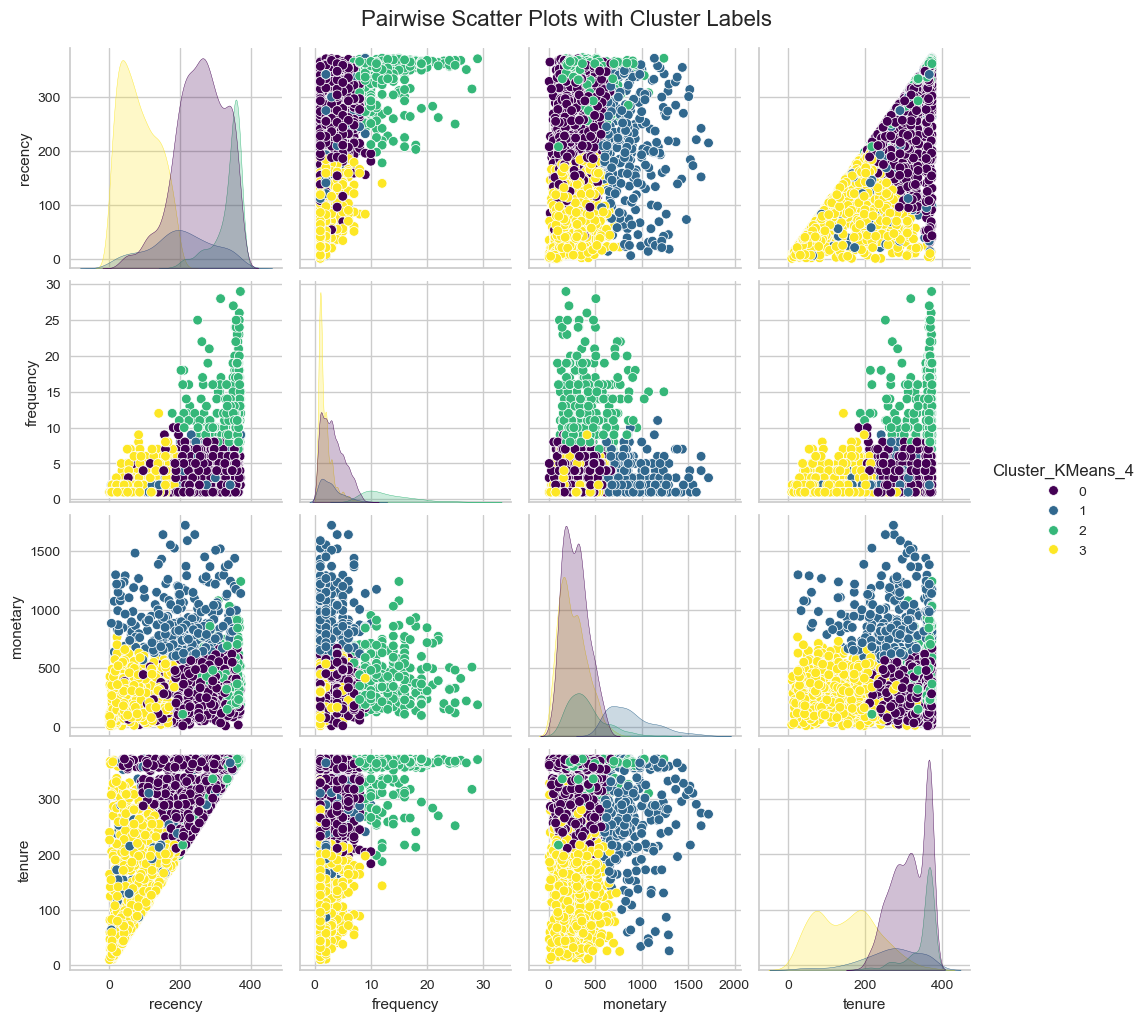

In [27]:
sns.pairplot(df, vars=['recency', 'frequency', 'monetary', 'tenure'], hue='Cluster_KMeans_4', palette='viridis')
plt.suptitle('Pairwise Scatter Plots with Cluster Labels', y=1.02, fontsize=16)
plt.show()

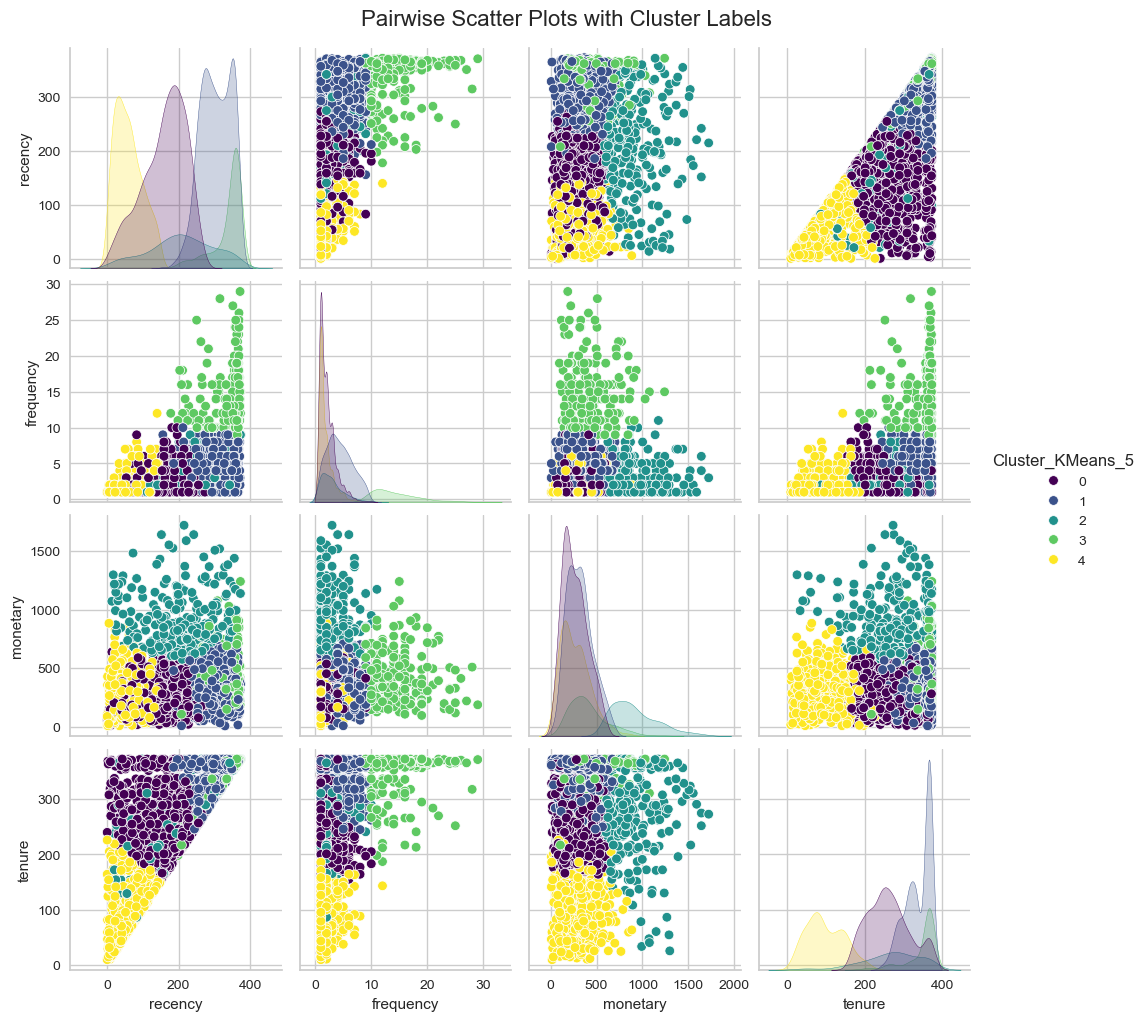

In [28]:
sns.pairplot(df, vars=['recency', 'frequency', 'monetary', 'tenure'], hue='Cluster_KMeans_5', palette='viridis')
plt.suptitle('Pairwise Scatter Plots with Cluster Labels', y=1.02, fontsize=16)
plt.show()

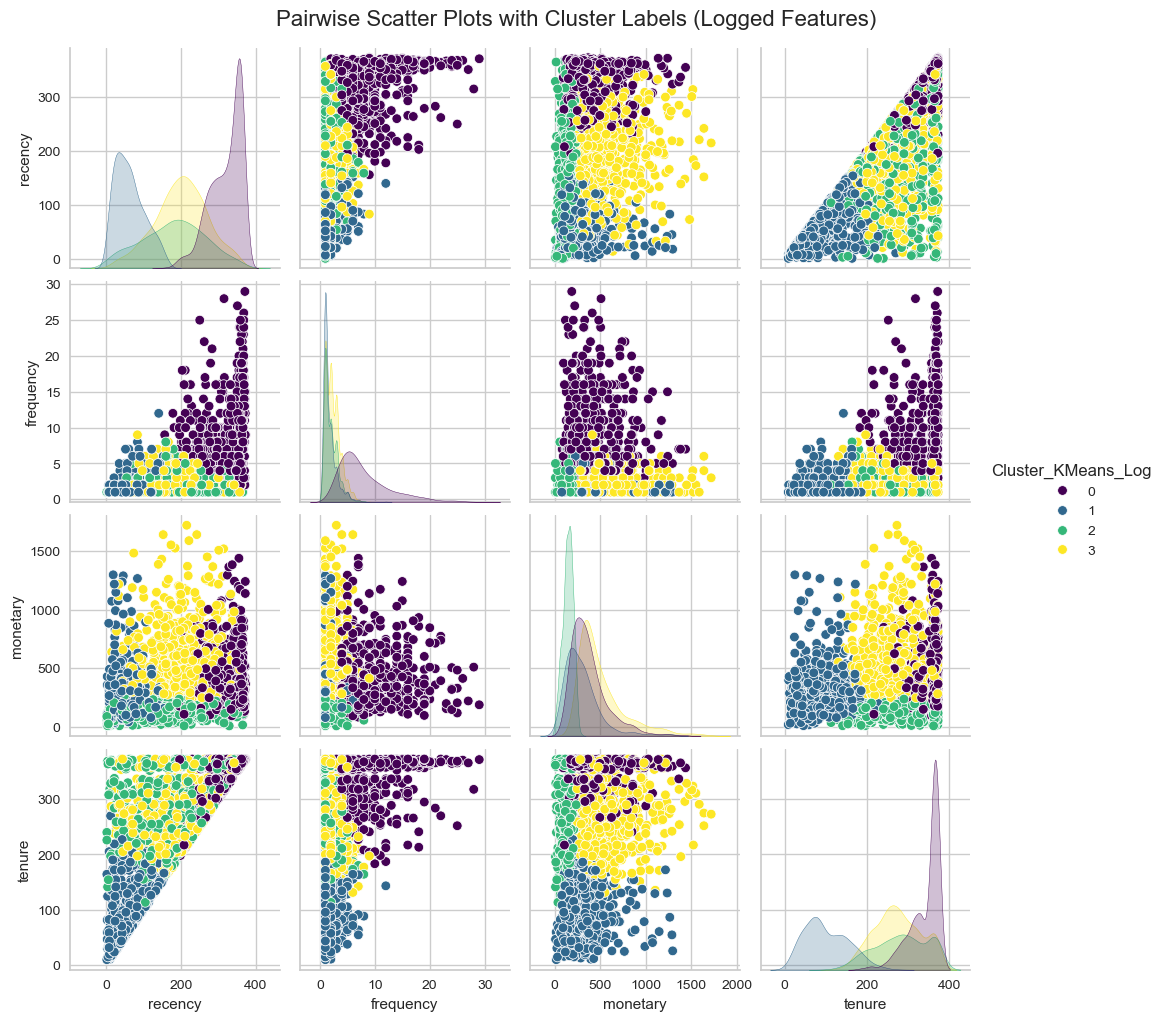

In [29]:
sns.pairplot(df, vars=['recency', 'frequency', 'monetary', 'tenure'], hue='Cluster_KMeans_Log', palette='viridis')
plt.suptitle('Pairwise Scatter Plots with Cluster Labels (Logged Features)', y=1.02, fontsize=16)
plt.show()

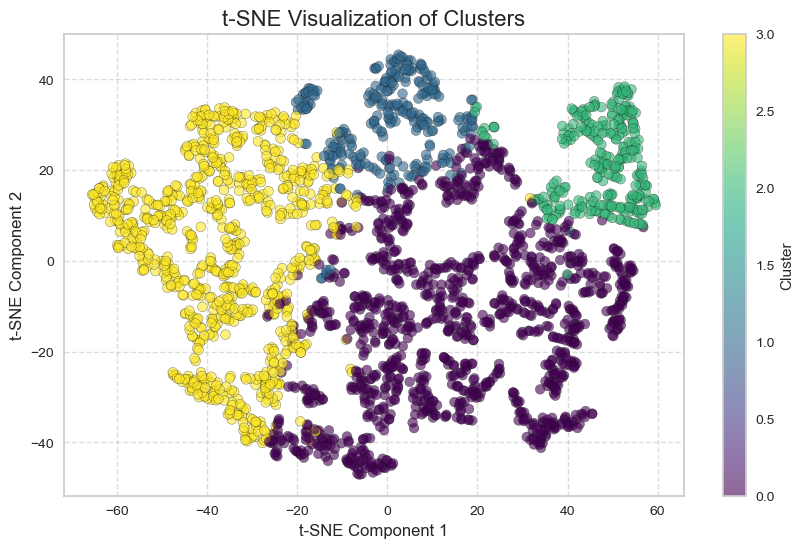

In [30]:
# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(df_features_scaled)

# Create a scatter plot of the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(
    tsne_features[:, 0], tsne_features[:, 1], 
    c=df['Cluster_KMeans_4'], cmap='viridis', alpha=0.6, edgecolors='k'
)
plt.title('t-SNE Visualization of Clusters', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.colorbar(label='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

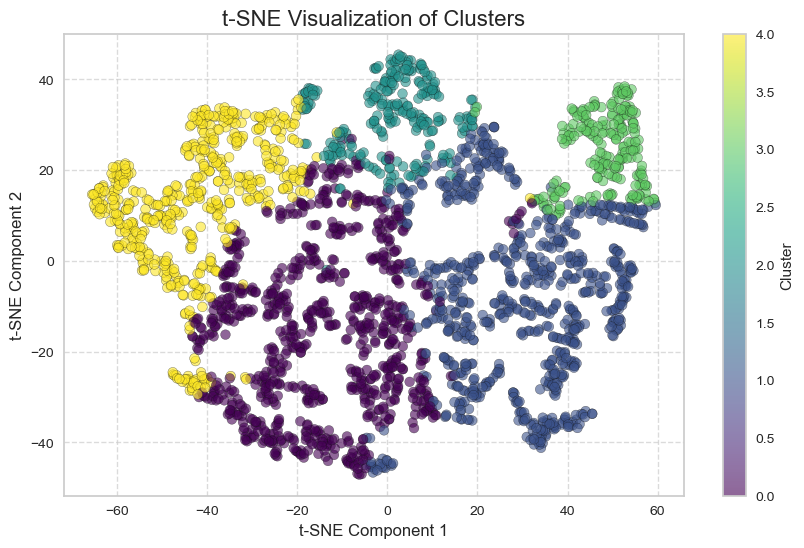

In [31]:
# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(df_features_scaled)

# Create a scatter plot of the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(
    tsne_features[:, 0], tsne_features[:, 1], 
    c=df['Cluster_KMeans_5'], cmap='viridis', alpha=0.6, edgecolors='k'
)
plt.title('t-SNE Visualization of Clusters', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.colorbar(label='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

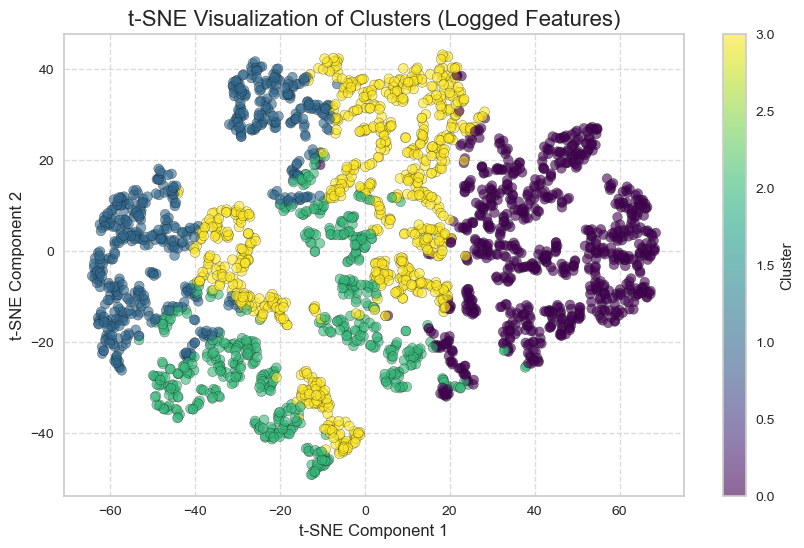

In [32]:
# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(df_features_log_scaled)

# Create a scatter plot of the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(
    tsne_features[:, 0], tsne_features[:, 1], 
    c=df['Cluster_KMeans_Log'], cmap='viridis', alpha=0.6, edgecolors='k'
)
plt.title('t-SNE Visualization of Clusters (Logged Features)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.colorbar(label='Cluster')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

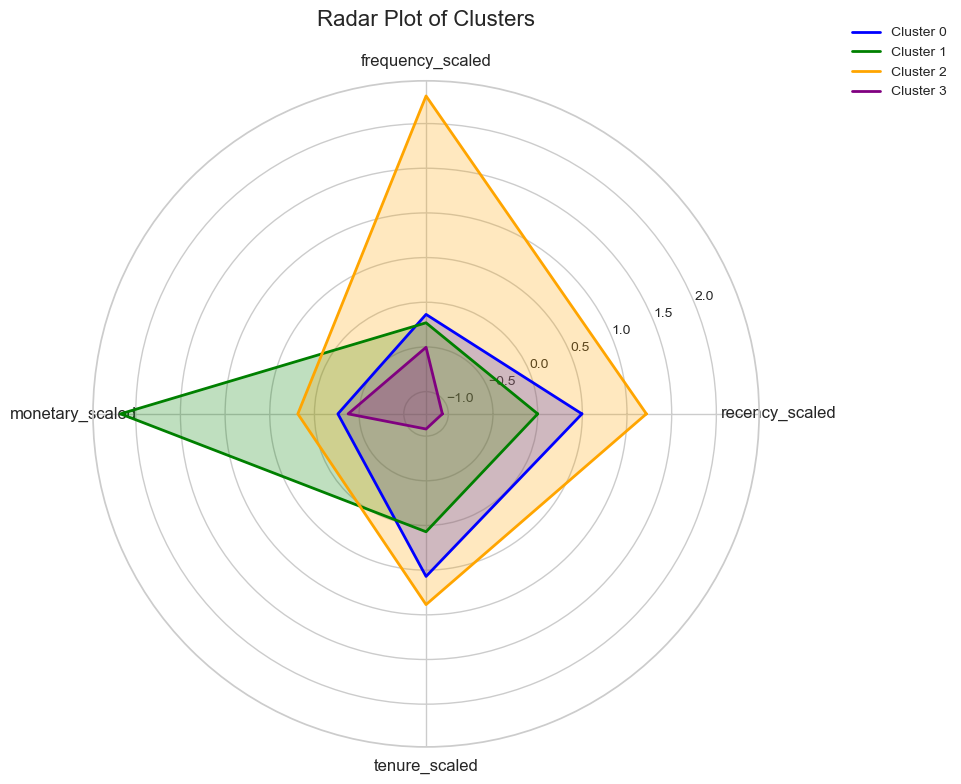

In [33]:
cluster_means = df_scaled.groupby('Cluster_KMeans_4')[['recency_scaled', 'frequency_scaled', 'monetary_scaled', 'tenure_scaled']].mean()
features = cluster_means.columns
num_clusters = cluster_means.shape[0]

# Create angles for radar plot
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the radar plot loop

# Initialize radar plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'polar': True})

# Plot each cluster
colors = ['blue', 'green', 'orange', 'purple', 'red']
for i in range(num_clusters):
    cluster_data = cluster_means.iloc[i].values
    cluster_data = np.append(cluster_data, cluster_data[0])  # Close the radar plot loop
    
    ax.plot(angles, cluster_data, linewidth=2, linestyle='solid', label=f'Cluster {i}', color=colors[i])
    ax.fill(angles, cluster_data, alpha=0.25, color=colors[i])

# Add feature labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=12)

# Add title and legend
ax.set_title('Radar Plot of Clusters', fontsize=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

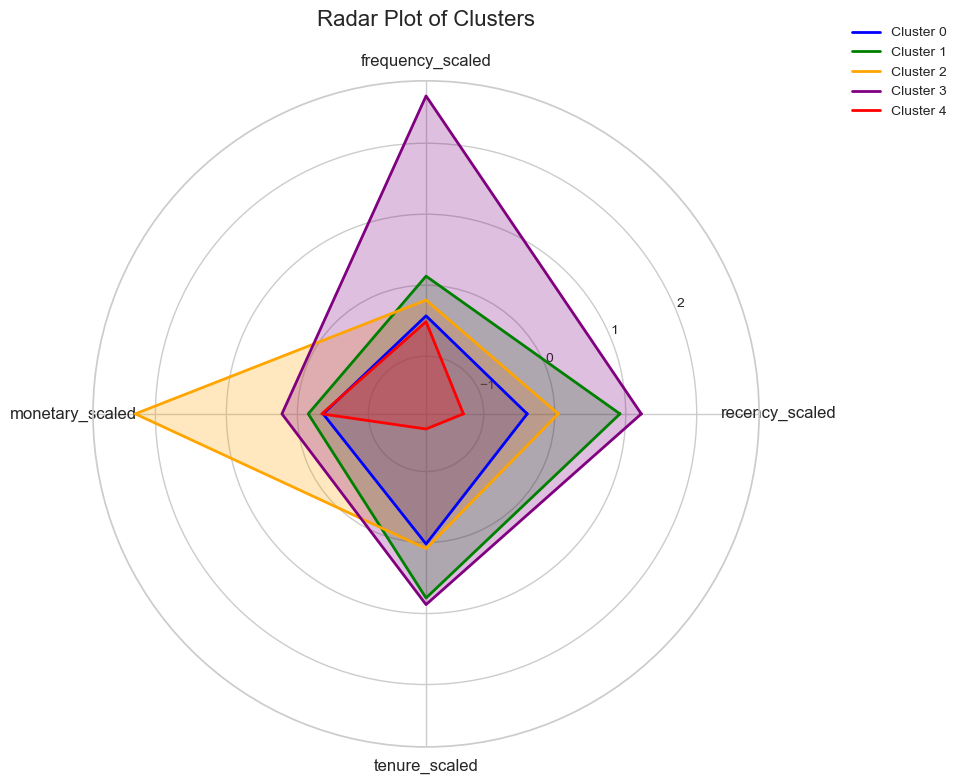

In [34]:
cluster_means = df_scaled.groupby('Cluster_KMeans_5')[['recency_scaled', 'frequency_scaled', 'monetary_scaled', 'tenure_scaled']].mean()
features = cluster_means.columns
num_clusters = cluster_means.shape[0]

# Create angles for radar plot
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the radar plot loop

# Initialize radar plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'polar': True})

# Plot each cluster
colors = ['blue', 'green', 'orange', 'purple', 'red']
for i in range(num_clusters):
    cluster_data = cluster_means.iloc[i].values
    cluster_data = np.append(cluster_data, cluster_data[0])  # Close the radar plot loop
    
    ax.plot(angles, cluster_data, linewidth=2, linestyle='solid', label=f'Cluster {i}', color=colors[i])
    ax.fill(angles, cluster_data, alpha=0.25, color=colors[i])

# Add feature labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=12)

# Add title and legend
ax.set_title('Radar Plot of Clusters', fontsize=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

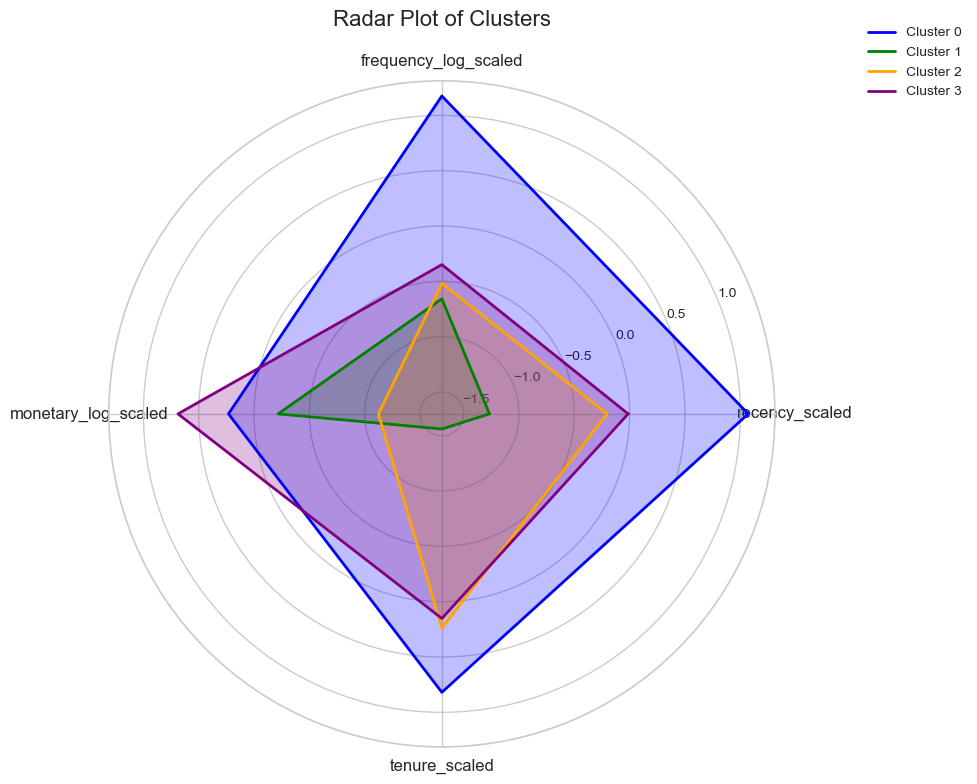

In [35]:
cluster_means = df_scaled_log.groupby('Cluster_KMeans')[['recency_scaled', 'frequency_log_scaled', 'monetary_log_scaled', 'tenure_scaled']].mean()
features = cluster_means.columns
num_clusters = cluster_means.shape[0]

# Create angles for radar plot
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the radar plot loop

# Initialize radar plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'polar': True})

# Plot each cluster
colors = ['blue', 'green', 'orange', 'purple']
for i in range(num_clusters):
    cluster_data = cluster_means.iloc[i].values
    cluster_data = np.append(cluster_data, cluster_data[0])  # Close the radar plot loop
    
    ax.plot(angles, cluster_data, linewidth=2, linestyle='solid', label=f'Cluster {i}', color=colors[i])
    ax.fill(angles, cluster_data, alpha=0.25, color=colors[i])

# Add feature labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=12)

# Add title and legend
ax.set_title('Radar Plot of Clusters', fontsize=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

**Silhouette Score:** Measures how similar a data point is to its own cluster compared to other clusters. Higher values indicate better-defined clusters. 

In [36]:
score_4 = silhouette_score(df_features_scaled, df['Cluster_KMeans_4'])
score_5 = silhouette_score(df_features_scaled, df['Cluster_KMeans_5'])
score_log = silhouette_score(df_features_log_scaled, df['Cluster_KMeans_Log'])

print(f"Silhouette Score (4 Clusters): {score_4}")
print(f"Silhouette Score (5 Clusters): {score_5}")
print(f"Silhouette Score (Log): {score_log}")

Silhouette Score (4 Clusters): 0.35884542363689176
Silhouette Score (5 Clusters): 0.3135005804666625
Silhouette Score (Log): 0.28148770428056386


**Calinski-Harabasz Score:** Measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate better clustering.

In [37]:
score_4 = calinski_harabasz_score(df_features_scaled, df['Cluster_KMeans_4'])
score_5 = calinski_harabasz_score(df_features_scaled, df['Cluster_KMeans_5'])
score_log = calinski_harabasz_score(df_features_log_scaled, df['Cluster_KMeans_Log'])

print(f"Calinski-Harabasz Score (4 Clusters): {score_4}")
print(f"Calinski-Harabasz Score (5 Clusters): {score_5}")
print(f"Calinski-Harabasz Score (Log): {score_log}")


Calinski-Harabasz Score (4 Clusters): 1543.6783932838298
Calinski-Harabasz Score (5 Clusters): 1573.1602074198333
Calinski-Harabasz Score (Log): 1376.7711630128624


**Davies-Bouldin Score:** Measures the average similarity ratio of each cluster with its most similar cluster.
Lower values indicate better clustering.

In [38]:
score_4 = davies_bouldin_score(df_features_scaled, df['Cluster_KMeans_4'])
score_5 = davies_bouldin_score(df_features_scaled, df['Cluster_KMeans_5'])
score_log = davies_bouldin_score(df_features_log_scaled, df['Cluster_KMeans_Log'])

print(f"Davies-Bouldin Score (4 Clusters): {score_4}")
print(f"Davies-Bouldin Score (5 Clusters): {score_5}")
print(f"Davies-Bouldin Score (Log): {score_log}")

Davies-Bouldin Score (4 Clusters): 0.9404163708665864
Davies-Bouldin Score (5 Clusters): 1.0059819506936587
Davies-Bouldin Score (Log): 1.2084243784237414


* **Silhouette Score:** 4 clusters win (0.359 vs 0.314). Suggests that 4 clusters are, on average, more dense and well-separated.
* **Calinski-Harabasz Score:** 5 clusters win (1573 vs 1544). Suggests that 5 clusters have a better ratio of variance *between* clusters to variance *within* clusters.
* **Davies-Bouldin Score:** 4 clusters win (0.94 vs 1.01). Suggests that 4 clusters have less similarity between them.

**Conclusion:** Statistically, the 4-cluster model is more mathematically distinct.

In [39]:
cluster_scorecard_4 = df.groupby('Cluster_KMeans_4')[['recency', 'frequency', 'monetary', 'tenure']].agg(['count', 'mean','std'])
display(cluster_scorecard_4)

cluster_scorecard_5 = df.groupby('Cluster_KMeans_5')[['recency', 'frequency', 'monetary', 'tenure']].agg(['count', 'mean','std'])
display(cluster_scorecard_5)


recency                        frequency             \
                   count        mean        std     count       mean   
Cluster_KMeans_4                                                       
0                   1210  256.182645  69.830248      1210   3.306612   
1                    277  201.765343  91.444918       277   2.935018   
2                    295  335.454237  40.341111       295  12.969492   
3                    899   84.439377  52.579238       899   1.850945   

                           monetary                         tenure  \
                       std    count        mean         std  count   
Cluster_KMeans_4                                                     
0                 1.951277     1210  288.445243  133.583869   1210   
1                 2.000752      277  883.745174  249.972074    277   
2                 4.465562      295  398.144602  195.061106    295   
3                 1.333159      899  260.495276  145.849505    899   

                                         
                        mean        std  
Cluster_KMeans_4                         
0                 316.375207  46.200373  
1                 265.978339  76.543960  
2                 348.179661  36.514347  
3                 150.007786  79.310285

recency                        frequency             \
                   count        mean        std     count       mean   
Cluster_KMeans_5                                                       
0                    856  159.066589  60.485069       856   2.137850   
1                    809  302.758962  41.832262       809   4.348578   
2                    250  207.092000  89.484308       250   3.016000   
3                    224  335.741071  42.205295       224  14.379464   
4                    542   60.273063  37.755356       542   1.809963   

                           monetary                         tenure  \
                       std    count        mean         std  count   
Cluster_KMeans_5                                                     
0                 1.451651      856  264.017762  135.224580    856   
1                 2.255823      809  315.277967  140.967135    809   
2                 2.069026      250  911.325813  246.749484    250   
3                 4.223968      224  405.933169  204.883754    224   
4                 1.324744      542  268.698351  160.414855    542   

                                         
                        mean        std  
Cluster_KMeans_5                         
0                 260.968458  54.394166  
1                 337.639061  32.859071  
2                 267.504000  74.878496  
3                 347.004464  38.984934  
4                  97.630996  48.078729

### BUSINESS INSIGHTS

**4 Cluster Solution:**
* Cluster 2: Best Customers
    - Count: 295
    - They have the **highest tenure** (348), the **longest active buying lifespan** (highest recency, 335), and the **highest purchase frequency by a huge margin** (13.0). They also have a high Average Order Value (AOV) of 398.
    - They buy often *and* spend a lot when they do.
* Cluster 1: Big-Ticket Spenders  
    - Count: 277
    - They have **exceptionally high Average Order Value (AOV)** (884). They have a moderate tenure (266) amd active lifespan (202). Their purchasing frequency is low (2.9), indicating they don't buy often. 
    - They don't buy often, but when they do, they spend significantly more than any other group.
* Cluster 0: Occasional / Established Customers
    - Count: 1210
    - They have a **high tenure** (316), meaning they've been with us for a long time. However, their active lifespan (256), frequency (3.3), and AOV (288) are all moderate-to-low. 
    - They are the largest segment of "average" established customers. They are loyal but not highly engaged.
* Cluster 3: New Repeat Customers  
    - Count: 899
    - They have the **lowest tenure** (150), **shortest active lifespan** (84), **lowest frequency** (1.9), and **lowest AOV** (260).
    - They just started their repeat-purchase journey. All of these metrics are low, which is expected for new customers.
 
**5 Cluster Solution:**
* Cluster 3: Best Customers 
    - Count: 224
    - They have been customers the longest (high tenure, 347), have the longest active buying lifespan (high recency, 336), and buy the **most frequently** (14.4). They also have a **high Average Order Value (AOV)** (406). 
    - They buy often *and* spend a lot when they do.
* Cluster 2: Big-Ticket Spenders  
    - Count: 250
    - They have **exceptionally high Average Order Value (AOV)** (911). They have a moderate tenure (268) and active lifespan (207). Their purchase frequency (3.0) is low, indicating they don't buy often. 
    - They don't buy often, but when they do, they spend significantly more than any other group.
* Cluster 1: Loyal Customers  
    - Count: 809
    - They have a long tenure (338) and a long active lifespan (303). They purchase with good frequency (4.3) and have a moderate AOV (315). 
    - They are the reliable repeat buyers.
* Cluster 0: At-Risk Customers  
    - Count: 856
    - Despite a moderate tenure (261 days), their active lifespan (159) and frequency (2.1) are very low. They also have the **lowest AOV** (264). 
    - They are the largest and least-engaged group. They made a couple of small repeat purchases but have likely disengaged.
* Cluster 4: New Repeat Customers  
    - Count: 542
    - They have the **lowest tenure** (98), **shortest active lifespan** (60), and **lowest frequency** (1.8). Their AOV (269) is also very low.
    - They just started their repeat-purchase journey. All of these metrics are low, which is expected for new customers.

The **5-cluster solution is more actionable**.

* Key advantage was splitting a large, vague "average" group into two distinct groups:
    * **Loyal Customers** (to *nurture*).
    * **At-Risk Customers** (to *reactivate*).
* The scores are not worse, and the business value gained from identifying that "at-risk" group is more important than achieving a slightly better statistical score.

### BUSINESS ACTIONS
- Cluster 3: Best Customers (VIPs)
    - Focus on loyalty rewards, exclusive access, and treating them as partners (e.g., soliciting feedback for new products).
- Cluster 2: Big-Ticket Spenders
    - Do not bombard them with low-value "buy now" messages. 
    - Target them with high-margin products, exclusive releases, and white-glove service. Their value is in *basket size*, not frequency.
- Cluster 1: Loyal Customers
    - Nurture this relationship to maintain loyalty. 
    - Focus on community-building and personalized up-selling to increase their AOV and move them toward the VIP bracket.
- Cluster 0: At-Risk Customers
    - This group needs re-activation. 
    - Target them with compelling offers to increase their AOV or incentives to make their next purchase. Analyze *why* their engagement stopped.
- Cluster 4: New Repeat Customers
    - The goal is to convert them into long-term loyal customers (like Cluster 1). 
    - Focus on onboarding, demonstrating value, and encouraging a 3rd or 4th purchase.

In [41]:
df = df[['CustomerID', 'frequency', 'recency', 'tenure', 'monetary', 'Cluster_KMeans_5']]

cluster_mapping = {
    3: "Best Customers",  
    2: "Big-Ticket Spenders",
    1: "Loyal Customers",  
    0: "At-Risk Low-Value Customers",  
    4: "New Repeat Customers"  
}

df['Cluster_KMeans_5'] = df['Cluster_KMeans_5'].map(cluster_mapping)

# Verify the changes
print(df['Cluster_KMeans_5'].value_counts())
df.head()

Cluster_KMeans_5
At-Risk Low-Value Customers    856
Loyal Customers                809
New Repeat Customers           542
Big-Ticket Spenders            250
Best Customers                 224
Name: count, dtype: int64


CustomerID  frequency  recency  tenure    monetary      Cluster_KMeans_5
0    12347.0        6.0    365.0   367.0  599.701667       Loyal Customers
1    12348.0        3.0    283.0   358.0  261.480000       Loyal Customers
2    12352.0        5.0    260.0   296.0  193.782000       Loyal Customers
3    12356.0        2.0    303.0   325.0  269.905000       Loyal Customers
4    12358.0        1.0    149.0   150.0  523.200000  New Repeat Customers

In [42]:
df.to_csv('data/customer_rfmt_cluster.csv', index=False)

TO DO:
- Analyze Anomalies
- Analyze One time spenders